# Serbia Energy Optimisation

This notebook is for analysing the results of optimisation of Serbian power plants in the context of new distributed solar power generation. The problem to be solved is to decide what production each plant should produce for each hour. 

Thus, it is the *unit commitment problem*. We have 24 plants, including a hypothetical decentalised solar power plant composed of many small solar units at the domestic level. We take the demand curve of a typical day and try to match it closely with the total supply. We try to minimize:

* production cost
* emissions
* sustainability cost
* environmental cost

We have used a weighting to combine these objectives to a single objective. We have used linear programming (LP) to optimise schedules. We have used four approaches -- two grid search methods, random search, and multiobjective evolutionary search -- to explore weightings. Each leads to a Pareto front of schedules, trading-off the objectives against each other. In this notebook, we read in all the data and investigate the distributions of the above objectives, and visualise the Pareto front among them.

## Implementation

The file `run.py` contains the implementation. It reads data from several `.csv` files. We have run the optimizer many times with different weights on the above objectives, and different seeds. This notebook only carries out analysis.

First, we import all the usual Python data/visualisation libraries.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Problem data: plant information and demand

In [2]:
plant_info = pd.read_csv("../data/plant_info_10.csv")

In [3]:
s = plant_info.to_latex(float_format="%.3f", 
                    index=False,
                    columns=["name", "type", "production_cost", "environment_cost", "sustainability_cost", "CO2", "lower_bound", "upper_bound", "distance"],
                    header=["Name", "Type", "Prod cost", "Env cost", "Sus cost", "Emissions", "LB", "UB", "Distance"]
                   )
print(s)

\begin{tabular}{llrrrrrrr}
\toprule
              Name &           Type & Prod cost & Env cost & Sus cost & Emissions &   LB &    UB & Distance \\
\midrule
            Vrla 1 &          hydro &     1.400 &    0.010 &    0.700 &     0.024 &   10 &    50 &  178.830 \\
            Vrla 2 &          hydro &     1.400 &    0.010 &    0.700 &     0.024 &    5 &    24 &  175.470 \\
            Vrla 3 &          hydro &     1.400 &    0.010 &    0.700 &     0.024 &    6 &    29 &  171.320 \\
            Vrla 4 &          hydro &     1.400 &    0.010 &    0.700 &     0.024 &    5 &    25 &  166.940 \\
          HE Pirot &          hydro &     1.400 &    0.010 &    0.700 &     0.024 &   16 &    80 &  162.140 \\
            HEDJ 1 &          hydro &     1.400 &    0.010 &    0.700 &     0.024 &  205 &  1026 &  152.780 \\
            HEDJ 2 &          hydro &     1.400 &    0.010 &    0.700 &     0.024 &   54 &   270 &  138.400 \\
       Ovčar Banja &          hydro &     1.400 &    0.010 &    0.7

In [4]:
demand = pd.read_csv("../data/demand.csv", names=["demand"])

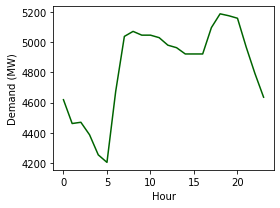

In [5]:
plt.figure(figsize=(4, 3))
sns.lineplot(demand.index, demand["demand"] / 1000, color="darkgreen", ax=plt.gca())
plt.xlabel("Hour")
plt.ylabel("Demand (MW)")
plt.tight_layout()
plt.savefig("../results/demand_curve.pdf")

The following calculates the Pareto front, given a 2D array, where each row is a point and each column is an objective.

In [33]:
# https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python

# Fairly fast for many datapoints, less fast for many costs, somewhat readable
def is_pareto_efficient_simple(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient


### Reading data

The following function reads a directory of result files containing objective values into a Pandas DataFrame.

In [93]:
def read_objvals_to_pd(d, obj_names):
    results = []
    filenames = []
    for f in os.listdir(d):
        if f.startswith("objvals_"):
            df = os.path.join(d, f)
            txt = open(df).read()
            result = eval(txt)
            result = [result[name] for name in obj_names]
            result.append(f)
            result.append(d)
            results.append(result)
    results = pd.DataFrame(results)
    return results

We list the four objectives of interest.

In [94]:
obj_names = [
    "technology_cost",
    "emissions",
    "env_cost",
    "sus_cost",
]

In the next cell, we read in the `objvals` results representing the Pareto front from each run, and get all the data into a single dataframe.

In [173]:
single_pfs = []
dirs = ["grid_search", 
        "grid_search2", 
        "random_search_seed_0", 
        "random_search_seed_1", 
        "pareto_archive_seed_0",
        "pareto_archive_seed_1",
        "pareto_archive_seed_2",
        "pareto_archive_seed_3",
        "pareto_archive_seed_4"]
for dir in dirs:
    if "seed" in dir:
        algo, seed = dir.split("_seed_")
    else:
        algo = dir
        seed = 0
    for solar in (0, 10, 50, 100):
        d = f"../results/{dir}/solar_{solar}/"
        pf = read_objvals_to_pd(d, obj_names)
        pf["solar_size"] = solar
        pf["algo"] = algo
        pf["seed"] = int(seed)
        pf.columns = ["Production cost", "Emissions", "Environmental cost", "Sustainability cost", "filename", "dirname", "New solar size (MW)", "algo", "seed"]
        pf.sort_values(by=["New solar size (MW)", "Production cost", "Emissions", "Environmental cost", "Sustainability cost"],
                       inplace=True)
        single_pfs.append(pf)
results_pf = pd.concat(single_pfs)

In [174]:
results_pf.head()

,Production cost,Emissions,Environmental cost,Sustainability cost,filename,dirname,New solar size (MW),algo,seed
6,4.858340e+08,7.488346e+07,1.369713e+08,2.147110e+08,objvals_algo_grid_search_solar_0_seed_0_3.dat,../results/grid_search/solar_0/,0,grid_search,0
1,4.858414e+08,7.479098e+07,1.368172e+08,2.145783e+08,objvals_algo_grid_search_solar_0_seed_0_8.dat,../results/grid_search/solar_0/,0,grid_search,0
5,4.858998e+08,7.472656e+07,1.367164e+08,2.144972e+08,objvals_algo_grid_search_solar_0_seed_0_7.dat,../results/grid_search/solar_0/,0,grid_search,0
3,4.860089e+08,7.463999e+07,1.365810e+08,2.143846e+08,objvals_algo_grid_search_solar_0_seed_0_4.dat,../results/grid_search/solar_0/,0,grid_search,0
2,4.862920e+08,7.449408e+07,1.363611e+08,2.142051e+08,objvals_algo_grid_search_solar_0_seed_0_5.dat,../results/grid_search/solar_0/,0,grid_search,0


### Comparing algorithms

We will take a quick look at a 2D view of the 4D Pareto front, obtained from each algorithm, for each solar scenario.

In [265]:
def make_comparison_plot(filename, results, xlabel, ylabel):

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12.5, 3.5))
    
    algo_names = {
        "grid_search": "Grid search",
        "grid_search2": "Grid search 2",
        "random_search": "Random search",
        "pareto_archive": "Pareto archive"
    }

    for i, algo in enumerate(algos):
        
        seed = 0
        
        pf = results[(results["algo"] == algo) & (results["seed"] == seed)]
        pf = pf.reset_index(drop=True)
        
        g = sns.scatterplot(
            x=xlabel,
            y=ylabel,
            data=pf, 
            s=15,
            hue="New solar size (MW)",
            palette=sns.cubehelix_palette(4, start=.5, rot=-.75, light=0.7, reverse=True),
            ax=ax[i],
            legend=("brief" if i == 3 else False)
        )
        
        
            
        ax[i].set_xlabel(xlabel if xlabel else "x")
        ax[i].set_ylabel(ylabel if i == 0 else None)

        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        if i != 0:
            g.set(yticklabels=[])
            #ax[i].set_xticks([])
        
        if i == 3:
            leg = g.get_legend()
            #g.add_legend()
            leg.set_bbox_to_anchor((0.6, 0.55))
            leg.draw_frame(True)
        
        ax[i].annotate(f"{algo_names[algo]}", xy=(0.04, 0.04), 
                       xycoords=ax[i].transAxes,
                      bbox=dict(boxstyle="square", fc="w"))


        
    for i, idx in enumerate(algos[:-1]):
        ax[i].set_xlim(ax[-1].get_xlim())
        ax[i].set_ylim(ax[-1].get_ylim())
        
    
    plt.tight_layout()
    plt.savefig(filename)

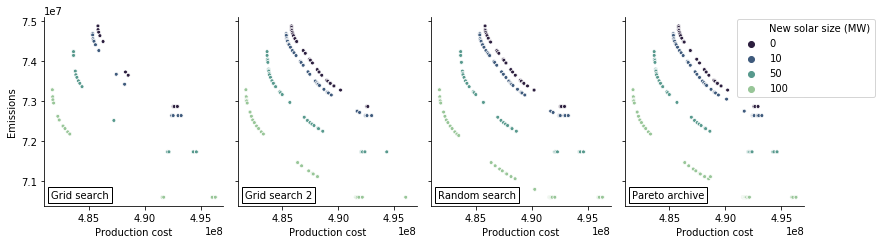

In [266]:
make_comparison_plot("compare_algorithms.pdf", results_pf, "Production cost", "Emissions")

### Pareto front progression

Next we create a plot showing how the Pareto front progresses over the generations, for a typical Pareto Archive run.

In [267]:
fronts = np.load("../results/pareto_archive_seed_0/generations_pareto_archive_100_0.npy", allow_pickle=True)

In [276]:
def make_generations_plot(filename, fronts, xlabel=None, ylabel=None):

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(11.5, 3.5))

    n = len(fronts)
    idxs = (0, 1, 3, n-1)
    for i, idx in enumerate(idxs):
        
        costs = fronts[idx]
        ax[i].scatter(costs[:, 0], costs[:, 1], 
                      label=f"Gen {idx}, size {len(costs)}", s=15,
                      c=[[0.61, 0.73, 0.61]],
                      edgecolor="w",
                      lw=0.5
                     )
        ax[i].set_xlabel(xlabel if xlabel else "x")
        
        #ax[i].text(0.6, 0.8, f"Gen {idx}", transform=ax[i].transAxes)
        ax[i].legend()
        
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        if i != 0:
            ax[i].set(yticklabels=[])
            #ax[i].set_xticks([])
        
        if i == 3:
            leg = ax[i].get_legend()
            #g.add_legend()
            #leg.set_bbox_to_anchor((0.6, 0.55))
            leg.draw_frame(True)        
        
    for i, idx in enumerate(idxs[:-1]):
        ax[i].set_xlim(ax[-1].get_xlim())
        ax[i].set_ylim(ax[-1].get_ylim())
        
    ax[0].set_ylabel(ylabel if ylabel else "y")
    plt.tight_layout()
    plt.savefig(filename)


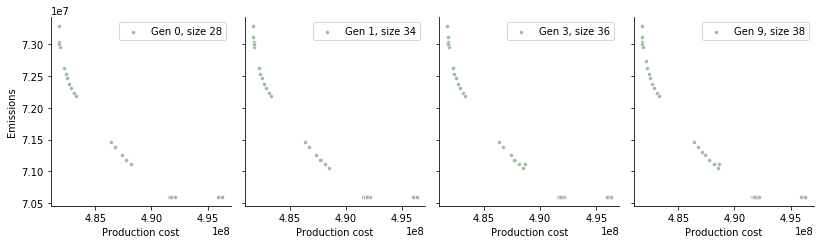

In [277]:
make_generations_plot("generations.pdf", fronts, "Production cost", "Emissions")

How many points in the PF, at each generation? 

In [120]:
for i, front in enumerate(fronts):
    print(i, front.shape[0])
    

0 28
1 34
2 34
3 36
4 36
5 37
6 37
7 37
8 38
9 38


### PairGrid plots for each algorithm

Next, we create a PairGrid plot which shows a scatterplot (bivariate distribution) for each pair of variables. On the diagonal we show the univariate distribution.

The next cell defines the main graph we want to make -- a PairGrid.

In [99]:
def make_pf_pairgrid(pf, algo):
    def diagfunc(x, **kws):
        ax = plt.gca()
        if kws["label"] == 0:
            ax.annotate("Best", xy=(0.1, 0.4), xycoords=ax.transAxes)
        ax.axvline(x=x.min(), ymin=0, ymax=0.3, linewidth=4, color=kws["color"])

    g = sns.PairGrid(pf, 
                     vars=["Production cost", "Emissions", "Environmental cost", "Sustainability cost"], 
                     hue="New solar size (MW)",
                     palette=sns.cubehelix_palette(4, start=.5, rot=-.75, light=0.7, reverse=True),
                     #palette=sns.color_palette("Set2"),
                     height=3, aspect=0.85
                    )
    g = g.map_diag(diagfunc)
    g = g.map_offdiag(plt.scatter, alpha=1, lw=0, s=8)
    g = g.add_legend()
    g._legend.set_bbox_to_anchor((0.25, 0.9))
    plt.tight_layout()
    plt.savefig(f"pareto_front_pairgrid_{algo}.pdf")
    plt.show()
    plt.close()

We see that a nice Pareto Front is formed between `production_cost` and `emissions`, showing that they trade-off against each other.

We also see that `emissions`, `env_cost` and `sus_cost` are closely correlated.

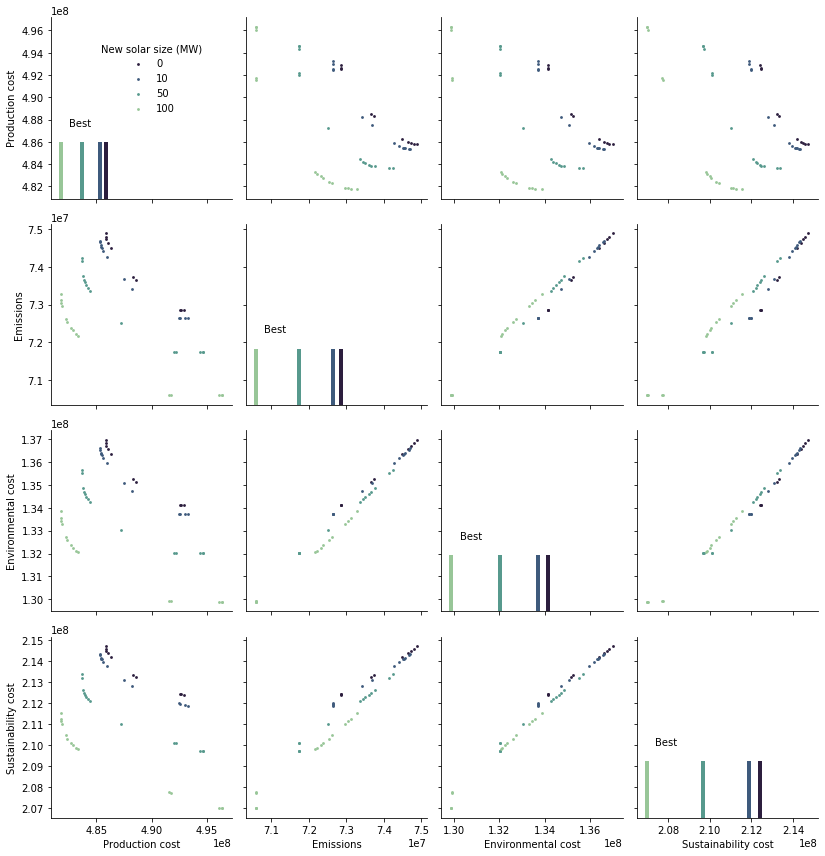

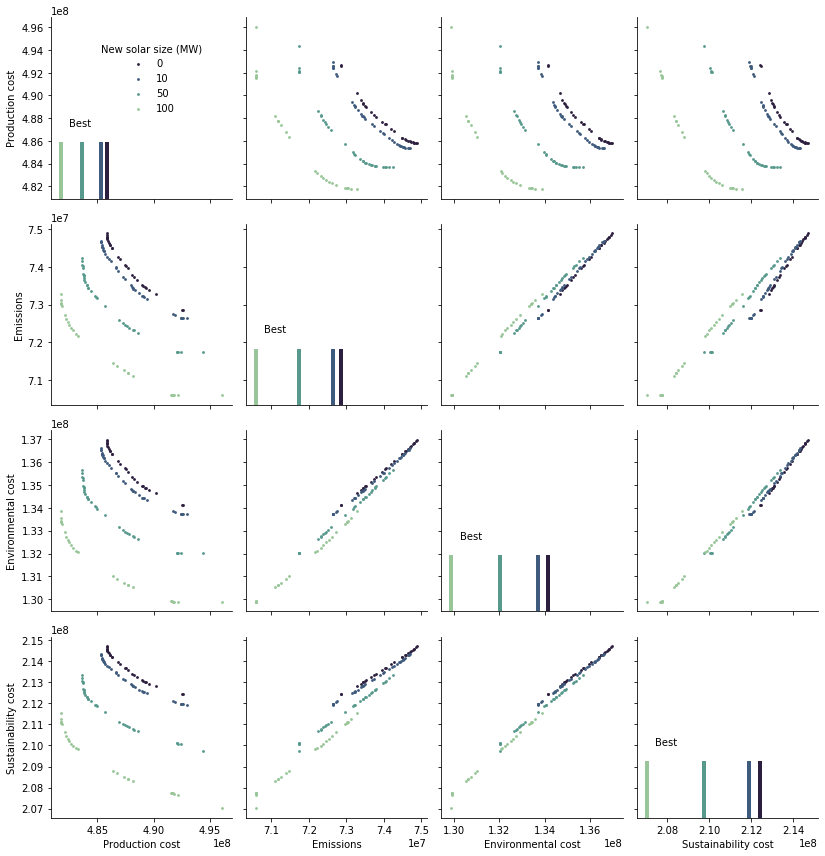

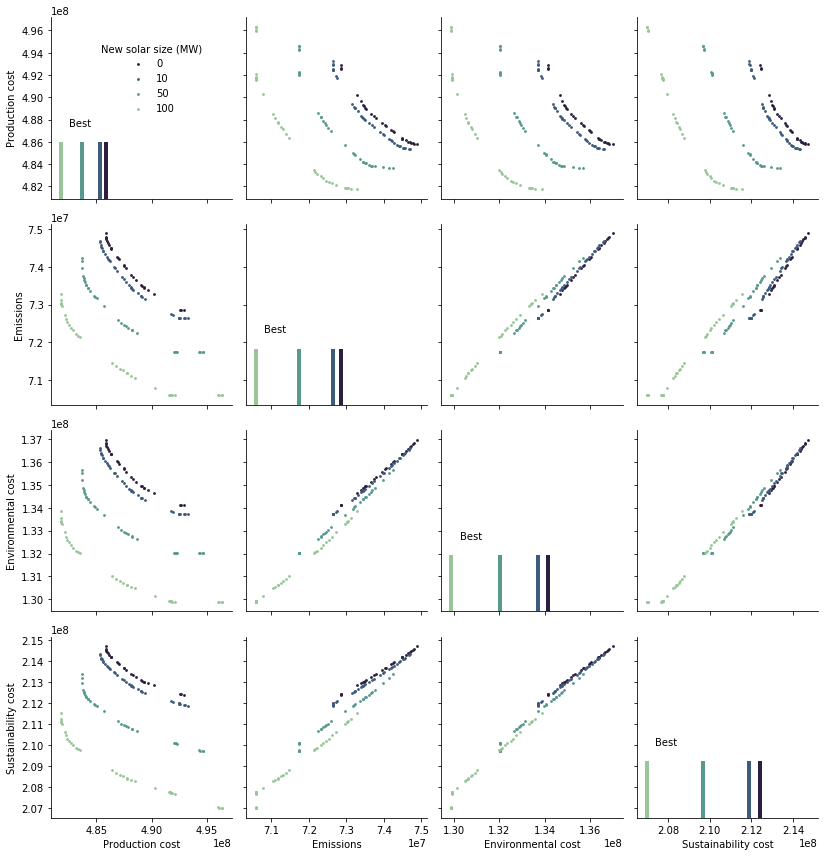

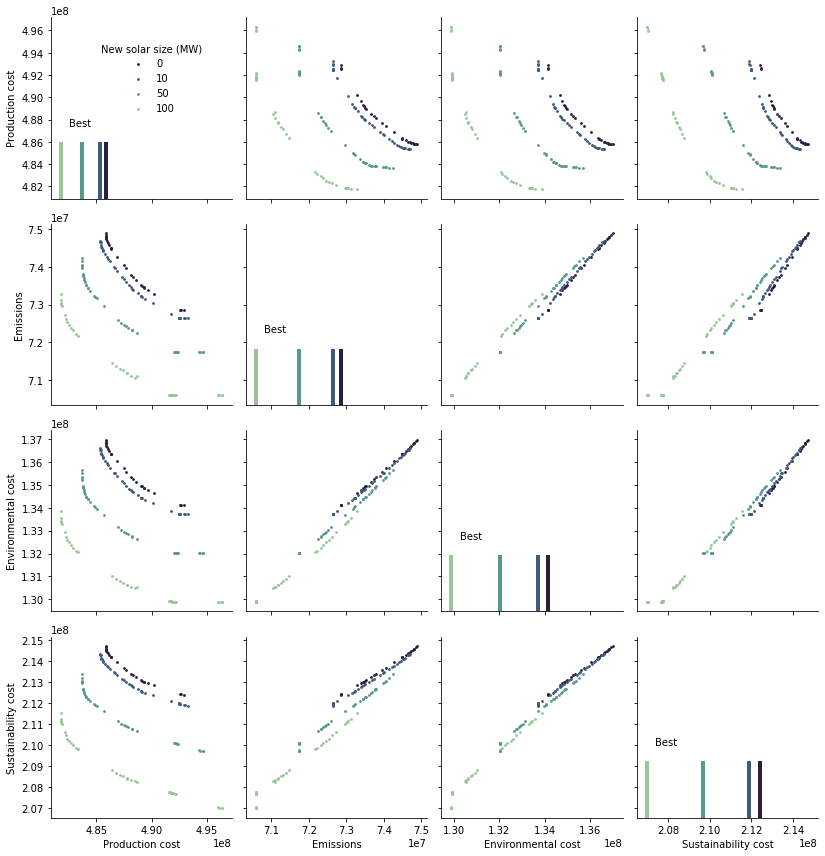

In [43]:
algos = ["grid_search", "grid_search2", "random_search", "pareto_archive"]
for algo in algos:
    seed = 0
    pf = results_pf[(results_pf["algo"] == algo) & (results_pf["seed"] == seed)]
    # print(pf)
    make_pf_pairgrid(pf, algo)

### Combining results

Up to now we have considered the algorithms separately.

Next we create a single DataFrame of combined results, and sort them by solar and then by costs, and reindex. 

In [100]:
combined = []
for solar in (0, 10, 50, 100):
    
    tmp = results_pf[results_pf["New solar size (MW)"] == solar]
    vals = tmp[["Production cost", "Emissions", "Environmental cost", "Sustainability cost"]].values
    pe = is_pareto_efficient_simple(vals)
    tmp = tmp.loc[pe, :]
    combined.append(tmp)
combined = pd.concat(combined)
combined.sort_values(by=["New solar size (MW)", "Production cost", "Emissions", "Environmental cost", "Sustainability cost"],
                   inplace=True)
combined = combined.reset_index(drop=True)  

Use that to create another PairGrid, this time for the combined results:

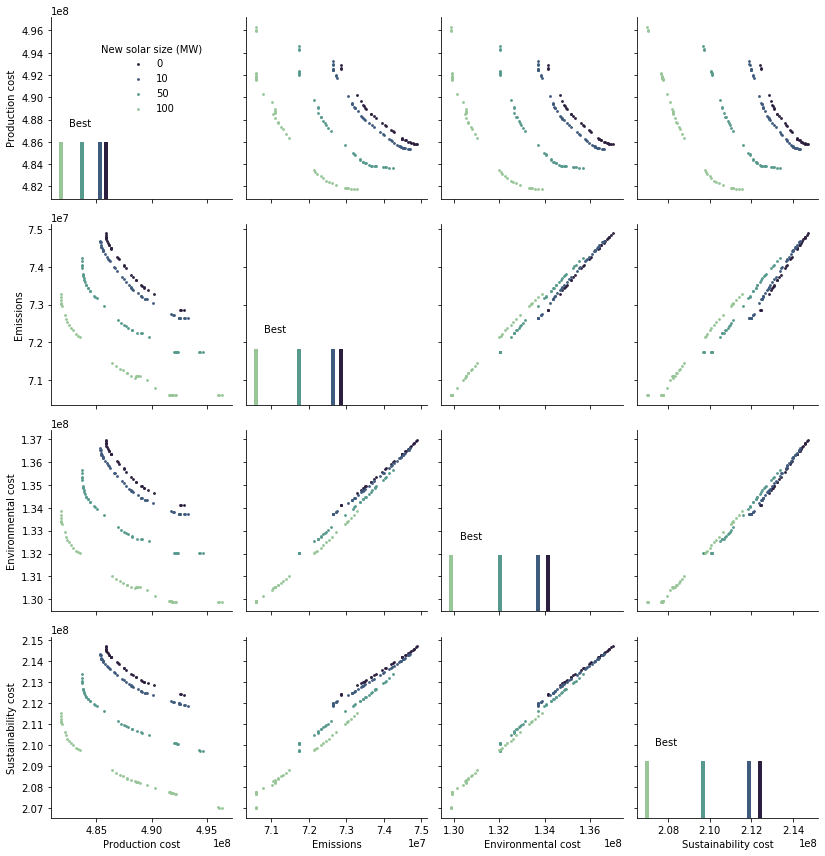

In [101]:
make_pf_pairgrid(combined, "combined")


### Table of combined results

Next we create a table of the PF of combined results for each solar value.

In [66]:
for solar in (0, 10, 50, 100):
    pf = combined[
                 (combined["New solar size (MW)"] == solar)
                 ]
    pf.sort_values(by=["Production cost", "Emissions", "Environmental cost", "Sustainability cost"],
                   inplace=True)
    pf = pf.reset_index(drop=True)    
    print(r"\begin{table}")
    caption = r"\caption{"
    label = r"\label{"
    end = r"}}"
    print(rf"{caption}Combined Pareto front. New solar size {solar}MW{label}tab:pareto_tab_{algo}_{solar}{end}")
    print(pf.to_latex(float_format="%.3e", 
                          index=True,
                          columns=["Production cost", "Emissions", "Environmental cost", "Sustainability cost"],
                          header=["Prod cost", "Emissions", "Env cost", "Sus cost"],
                         ))
    print(r"\end{table}")


\begin{table}
\caption{Combined Pareto front. New solar size 0MW\label{tab:pareto_tab_pareto_archive_0}}
\begin{tabular}{lrrrr}
\toprule
{} & Prod cost & Emissions &  Env cost &  Sus cost \\
\midrule
0  & 4.858e+08 & 7.488e+07 & 1.370e+08 & 2.147e+08 \\
1  & 4.858e+08 & 7.485e+07 & 1.369e+08 & 2.147e+08 \\
2  & 4.858e+08 & 7.479e+07 & 1.368e+08 & 2.146e+08 \\
3  & 4.858e+08 & 7.479e+07 & 1.368e+08 & 2.146e+08 \\
4  & 4.859e+08 & 7.477e+07 & 1.368e+08 & 2.145e+08 \\
5  & 4.859e+08 & 7.473e+07 & 1.367e+08 & 2.145e+08 \\
6  & 4.860e+08 & 7.468e+07 & 1.367e+08 & 2.144e+08 \\
7  & 4.860e+08 & 7.464e+07 & 1.366e+08 & 2.144e+08 \\
8  & 4.861e+08 & 7.458e+07 & 1.365e+08 & 2.143e+08 \\
9  & 4.861e+08 & 7.457e+07 & 1.365e+08 & 2.143e+08 \\
10 & 4.863e+08 & 7.449e+07 & 1.364e+08 & 2.142e+08 \\
11 & 4.863e+08 & 7.449e+07 & 1.364e+08 & 2.142e+08 \\
12 & 4.863e+08 & 7.449e+07 & 1.364e+08 & 2.142e+08 \\
13 & 4.863e+08 & 7.448e+07 & 1.363e+08 & 2.142e+08 \\
14 & 4.869e+08 & 7.427e+07 & 1.360e+08 & 2.1

/Users/jmmcd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


### Tables of best results by objective

In the following, we print out exact results for the single best point on each individual objective. We don't expect these points to be competitive when judged on multiple objectives simultaneously.

In [104]:
for solar in (0, 10, 50, 100):
    pf = combined[(combined["New solar size (MW)"] == solar)]
    pf = pf.reset_index(drop=True)
    print(f"SOLAR {solar} ######################")
    for k in ["Production cost", "Emissions", "Environmental cost", "Sustainability cost"]:
        i = pf[k].idxmin()
        print("Best", k, ", at row", i)
        print(pf.iloc[i])
        print("")

SOLAR 0 ######################
Best Production cost , at row 0
Production cost                                          4.85834e+08
Emissions                                                7.48835e+07
Environmental cost                                       1.36971e+08
Sustainability cost                                      2.14711e+08
filename               objvals_algo_grid_search_solar_0_seed_0_3.dat
dirname                              ../results/grid_search/solar_0/
New solar size (MW)                                                0
algo                                                     grid_search
seed                                                               0
Name: 0, dtype: object

Best Emissions , at row 31
Production cost                                          4.92647e+08
Emissions                                                7.28664e+07
Environmental cost                                       1.34137e+08
Sustainability cost                                      2

We would like to compare the best possible value on each objective, between 0MW and 100MW.

In [105]:
def improvement_percent(x, y):
    return 100 * (x - y) / x
pf0 = combined[(combined["New solar size (MW)"] == 0)]
pf100 = combined[(combined["New solar size (MW)"] == 100)]
tab = []
for k in ["Production cost", "Emissions", "Environmental cost", "Sustainability cost"]:
    v0 = pf0[k].min()
    v100 = pf100[k].min()
    tab.append((k, v0, v100, str(round(improvement_percent(v0, v100), 1))))
df = pd.DataFrame(tab, columns=["Objective", "best (0MW)", "best (100MW)", "improvement (%)"])
print(df.to_latex(float_format="%.3e", 
                          index=False))

\begin{tabular}{lrrl}
\toprule
           Objective &  best (0MW) &  best (100MW) & improvement (\%) \\
\midrule
     Production cost &   4.858e+08 &     4.818e+08 &             0.8 \\
           Emissions &   7.287e+07 &     7.059e+07 &             3.1 \\
  Environmental cost &   1.341e+08 &     1.299e+08 &             3.2 \\
 Sustainability cost &   2.124e+08 &     2.070e+08 &             2.6 \\
\bottomrule
\end{tabular}



### Visualising schedules

Next we are going to plot some schedules as heatmaps.

First we find the two schedules of min Env cost (for 0MW and 100MW), and then same for min Production cost - these are is to demonstrate how the extra 100MW changes things.

In [106]:
solar = 0
pf = combined[(combined["New solar size (MW)"] == solar)]
pf[
    (pf["Environmental cost"] == pf["Environmental cost"].min())
  ]



,Production cost,Emissions,Environmental cost,Sustainability cost,filename,dirname,New solar size (MW),algo,seed
32,4.929274e+08,7.286668e+07,1.341367e+08,2.124108e+08,objvals_algo_grid_search_solar_0_seed_0_1.dat,../results/grid_search/solar_0/,0,grid_search,0


In [107]:
solar = 100 # 100MW
pf = combined[(combined["New solar size (MW)"] == solar)]
pf[
    (pf["Environmental cost"] == pf["Environmental cost"].min())
  ]

,Production cost,Emissions,Environmental cost,Sustainability cost,filename,dirname,New solar size (MW),algo,seed
162,4.963123e+08,7.059351e+07,1.298906e+08,2.069894e+08,objvals_algo_grid_search_solar_100_seed_0_1.dat,../results/grid_search/solar_100/,100,grid_search,0


In [108]:
solar = 0
pf = combined[(combined["New solar size (MW)"] == solar)]
pf[
    (pf["Production cost"] == pf["Production cost"].min())
  ]

,Production cost,Emissions,Environmental cost,Sustainability cost,filename,dirname,New solar size (MW),algo,seed
0,4.858340e+08,7.488346e+07,1.369713e+08,2.147110e+08,objvals_algo_grid_search_solar_0_seed_0_3.dat,../results/grid_search/solar_0/,0,grid_search,0


In [109]:
solar = 100 # 100MW
pf = combined[(combined["New solar size (MW)"] == solar)]
pf[
    (pf["Production cost"] == pf["Production cost"].min())
  ]

,Production cost,Emissions,Environmental cost,Sustainability cost,filename,dirname,New solar size (MW),algo,seed
119,4.817631e+08,7.328562e+07,1.338606e+08,2.115401e+08,objvals_algo_grid_search_solar_100_seed_0_4.dat,../results/grid_search/solar_100/,100,grid_search,0


Next we find two schedules on opposite sides of a "gap" in the 100MW PF. This is to demonstrate the step-change in strategy.

In [110]:
solar = 100
pf = combined[(combined["New solar size (MW)"] == solar)]
pf[
    (4.834e8 < pf["Production cost"]) & (pf["Production cost"] < 4.85e8) # LHS of the gap
  ]



,Production cost,Emissions,Environmental cost,Sustainability cost,filename,dirname,New solar size (MW),algo,seed
134,4.834812e+08,7.213975e+07,1.320017e+08,2.097578e+08,objvals_algo_random_search_solar_100_seed_0_30...,../results/random_search_seed_0/solar_100/,100,random_search,0


In [111]:
solar = 100 # 100MW
pf = combined[(combined["New solar size (MW)"] == solar)]
pf[
    (4.85e8 < pf["Production cost"]) & (pf["Production cost"] < 4.865e8) # RHS of the gap
  ]

,Production cost,Emissions,Environmental cost,Sustainability cost,filename,dirname,New solar size (MW),algo,seed
135,4.863800e+08,7.146196e+07,1.310240e+08,2.087913e+08,objvals_algo_grid_search2_solar_100_seed_0_11.dat,../results/grid_search2/solar_100/,100,grid_search2,0


min_env_cost_0MW
relative_supply_algo_grid_search_solar_0_seed_0_1.csv
min_prod_cost_0MW
relative_supply_algo_grid_search_solar_0_seed_0_3.csv
min_env_cost_100MW
relative_supply_algo_grid_search_solar_100_seed_0_1.csv
min_prod_cost_100MW
relative_supply_algo_grid_search_solar_100_seed_0_4.csv
LHS_of_gap_100MW
relative_supply_algo_random_search_solar_100_seed_0_30.csv
RHS_of_gap_100MW
relative_supply_algo_grid_search2_solar_100_seed_0_11.csv


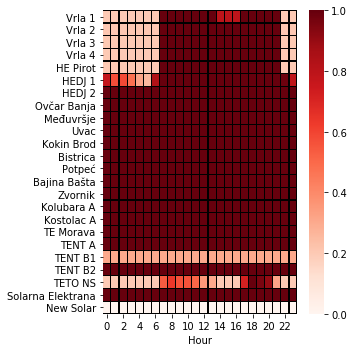

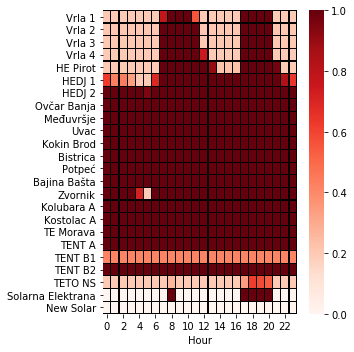

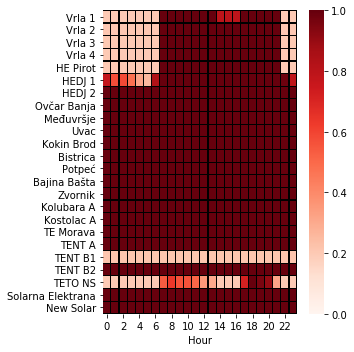

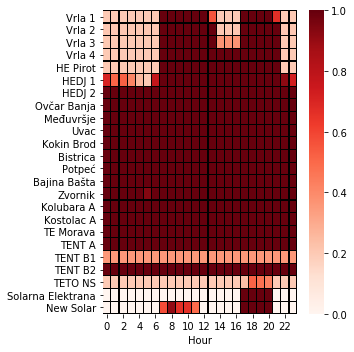

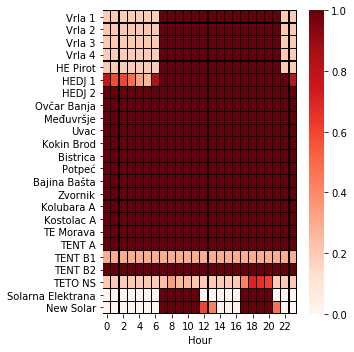

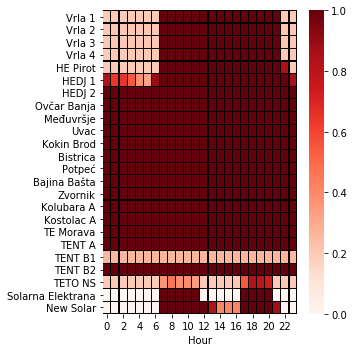

In [128]:
to_do = [(0, 32, "min_env_cost_0MW"),
         (0, 0, "min_prod_cost_0MW"),
         (100, 162, "min_env_cost_100MW"),
         (100, 119, "min_prod_cost_100MW"),
         (100, 134, "LHS_of_gap_100MW"),
         (100, 135, "RHS_of_gap_100MW")]

for solar, idx, title in to_do:
    pf = combined[(combined["New solar size (MW)"] == solar)]
    # pf = pf.reset_index(drop=True)
    f = pf.loc[idx]["filename"]
    d = pf.loc[idx]["dirname"]
    algo = pf.loc[idx]["algo"] # f.split("_algo_")[1].split("_solar_")[0]
    f = f.replace("objvals", "relative_supply").replace(".dat", ".csv")
    
    print(title)
    print(f)
    plt.figure(figsize=(5,5))
    xbest = np.genfromtxt(os.path.join(d, f), delimiter=" ")
    plant_info = pd.read_csv("../data/plant_info.csv")
    heatmap = sns.heatmap(xbest, cmap="Reds", linewidths=0.1, linecolor="k", vmin=0, vmax=1);
    heatmap.set_xlabel("Hour")
    heatmap.set_yticklabels(plant_info["name"], rotation=0);
    plt.tight_layout()
    plt.savefig(f"schedule_{algo}_{solar}_{idx}_{title}.pdf")